# Домашнее задание 5

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 17 марта. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_5

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим задачу минимизации:
\begin{equation}
\min_{x \in \mathbb{R}^d} f(x) = \frac{1}{2}x^T A x - b^T x,
\end{equation}
где в качестве матрицы $A$ - случайная матрица с $L =1000$, $\mu = 1$, $d = 100$, $b$ - так же случайный вектор.

__(а)__ Для такой задачи симулируем итерацию SGD:
$$
x^{k+1} = x^k - \gamma (\nabla f(x^k) + \xi^k),
$$
где $\xi^k$ - независимая от $x^k$ случайная величина из нормального распределения $\mathcal{N}(0, 100)$.

Для такого метода с $\gamma = \frac{1}{L}$ постройте график сходимости (критерий $\| \nabla f(x^k)\|^2$). Постройте на этом же графике сходимость честного градиентного спуска c $\gamma = \frac{1}{L}$. Сделайте вывод о характере сходимости нового метода.

In [40]:
import numpy as np 
import matplotlib.pyplot as plt 
import math  
import time 
from numpy import linalg   
import random 

In [41]:
random.seed(42)

In [42]:
def rvs(dim=3):
     random_state = np.random
     H = np.eye(dim)
     D = np.ones((dim,))
     for n in range(1, dim):
         x = random_state.normal(size=(dim-n+1,))
         D[n-1] = np.sign(x[0])
         x[0] -= D[n-1]*np.sqrt((x*x).sum())
         # Householder transformation
         Hx = (np.eye(dim-n+1) - 2.*np.outer(x, x)/(x*x).sum())
         mat = np.eye(dim)
         mat[n-1:, n-1:] = Hx
         H = np.dot(H, mat)
     D[-1] = (-1)**(1-(dim % 2))*D.prod()
     H = (D*H.T).T
     return H
    
def generate_matrix(d, m, L):  
    A = np.eye(d) 
    A[0, 0] = L
    A[1, 1] = m
    S = rvs(d) 
    A = np.dot(np.linalg.inv(S), np.dot(A, S))
    return A 

In [43]:
class SGD:  
    def __init__(self, max_iter = 2000, L = 1000, mu = 1, d = 100): 
        self.L = L 
        self.mu = mu 
        self.d = d 
        self.grad_history = [] 
        self.x = None  
        self.A = generate_matrix(d, mu, L)  
        self.b = np.random.normal(size = (d,)) 
        self.alpha = 1/L  
        self.max_iter = max_iter
    
    def grad(self): 
        return  1/2 * np.dot((self.A.T + self.A), self.x) - self.b 
    
    def fit(self): 
        new_x = np.zeros(self.d)  
        self.x = np.zeros(self.d)
        for i in range(self.max_iter):  
            g = self.grad()
            new_x = self.x - self.alpha * (g + np.random.normal(0, 10, self.d)) 
            self.grad_history.append(np.linalg.norm(g)**2) 
            self.x = new_x 

In [44]:
class GradientDescent: 
    def __init__(self, max_iter = 2000, L = 1000, mu = 1, d = 100): 
        self.L = L 
        self.mu = mu 
        self.d = d 
        self.grad_history = [] 
        self.x = None  
        self.A = generate_matrix(d, mu, L)  
        self.b = np.random.normal(size = (d,)) 
        self.alpha = 1/L  
        self.max_iter = max_iter
    
    def grad(self): 
        return 1/2 * np.dot((self.A + self.A.T), self.x) - self.b  
    
    def fit(self): 
        self.x = np.zeros(self.d) 
        new_x = np.zeros(self.d)
        for i in range(self.max_iter):   
            g = self.grad() 
            self.grad_history.append(np.linalg.norm(g)**2)
            new_x = self.x - self.alpha * g
            self.x = new_x   

In [45]:
gd = GradientDescent() 
sgd = SGD() 

In [46]:
gd.fit() 
sgd.fit()

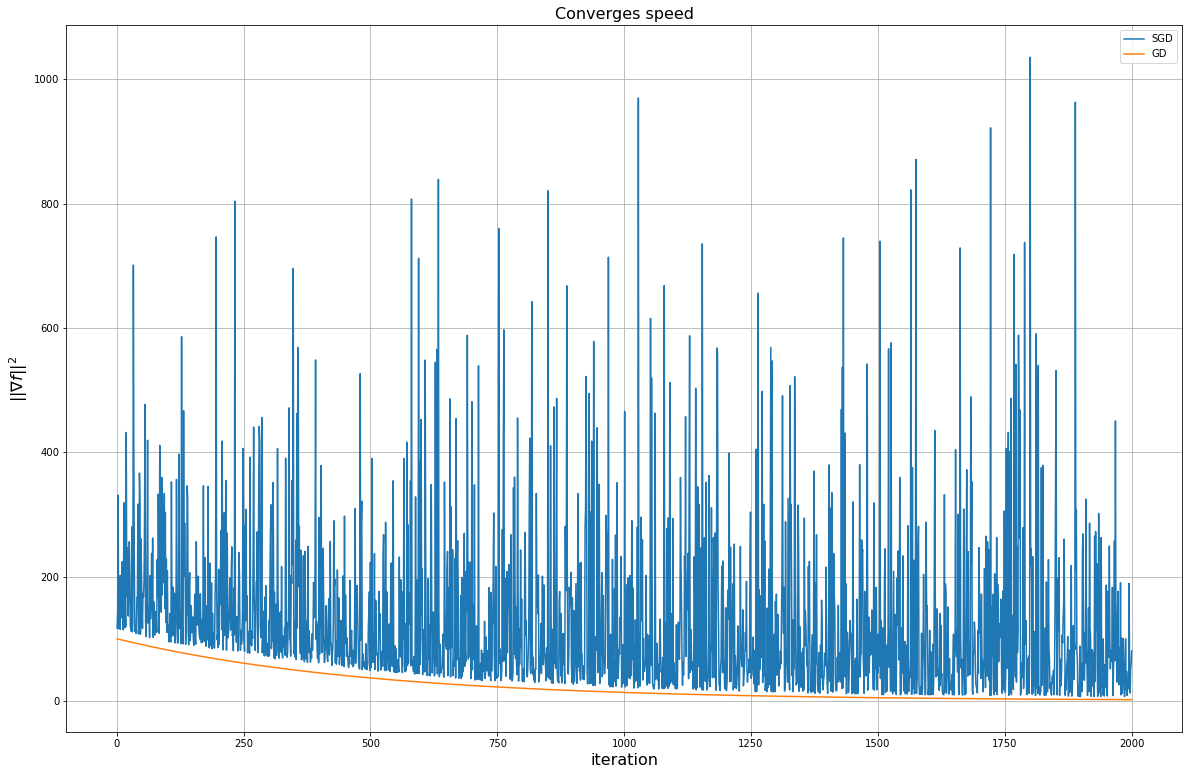

In [47]:
plt.figure(figsize=(20,13))  
plt.plot(range(1, sgd.max_iter + 1, 1), sgd.grad_history, label = 'SGD') 
plt.plot(range(1, gd.max_iter + 1, 1), gd.grad_history, label = 'GD') 
plt.title('Converges speed', fontsize=16) 
plt.xlabel('iteration', fontsize=16) 
plt.ylabel(r"$||\nabla f ||^{2}$", fontsize=16) 
plt.legend() 
plt.grid() 
plt.show() 

__(б)__ На семинаре обсуждались способы борьбы со "стохастичностью" сходимости градиентного спуска. В частности, мы затронули использование уменьшающегося шага (смотри, например, Теорему 5 из [работы](https://arxiv.org/pdf/1907.04232.pdf)), а также использование батчирования (в нашем случае это просто замена: $\xi^k \to \frac{1}{b} \sum\limits_{i=1}^b \xi^k_i$, где $\xi^k_i \in \mathcal{N}(0, 100)$ и независимы). Реализуйте эти модификации (для батчирования возьмите $b = 10 , 100$). Добавьте полученные результаты на график сходимости из пункта (а). Постройте также график сходимости, где по оси $x$ будет не количество итераций, а количество генераций $\xi^k_i$ (количество вызовов стохастического градиента).

In [48]:
#u means update SGD 
class USGD: 
    def __init__(self, batch_size = 10, max_iter = 2000, L = 1000, mu = 1, d = 100): 
        self.L = L 
        self.mu = mu 
        self.d = d 
        self.grad_history = [] 
        self.x = None  
        self.A = generate_matrix(d, mu, L)  
        self.b = np.random.normal(size = (d,)) 
        self.alpha = 1/L
        self.max_iter = max_iter 
        self.batch_size = batch_size 
    
    def grad(self): 
        return  1/2 * np.dot((self.A.T + self.A), self.x) - self.b 
    
    #we assume that d = L, a = mu  
    def fit(self): 
        new_x = np.zeros(self.d)  
        self.x = np.zeros(self.d)
        for i in range(1, self.max_iter + 1, 1):  
            g = self.grad()
            s = 0 
            for i in range(self.batch_size): 
                s += np.random.normal(0, 10, self.d) 
            s /= self.batch_size 
            new_x = self.x - self.alpha * (g + s) 
            self.grad_history.append(np.linalg.norm(g)**2) 
            self.x = new_x  
            if(i <= 2 * self.L/self.mu): 
                self.alpha = 1/(2 * self.L)
            elif(i > self.L/self.mu and i < self.max_iter/2): 
                self.alpha = 1/(2 * self.L) 
            else: 
                self.alpha = 2 / (self.mu * (4 * L / self.mu + i - self.max_iter//2))

In [49]:
usgd_1 = USGD(10)  
usgd_2 = USGD(100) 

usgd_1.fit() 
usgd_2.fit() 

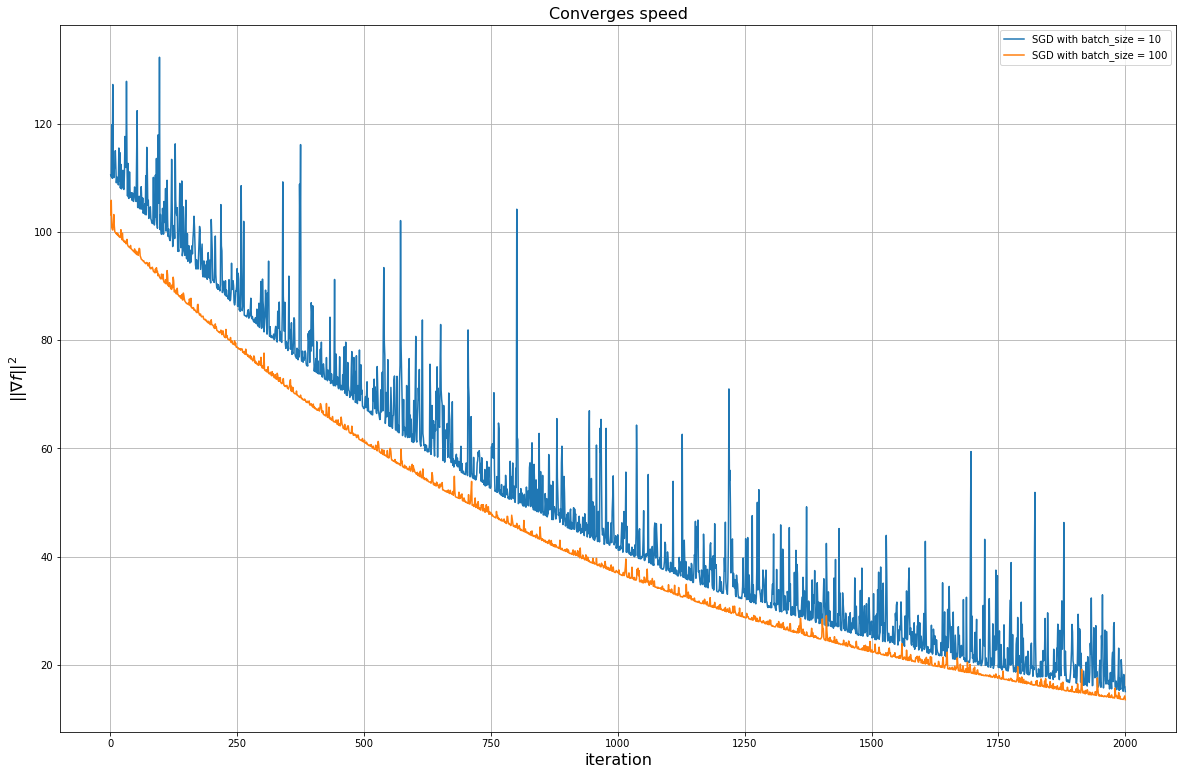

In [50]:
plt.figure(figsize=(20,13))  
plt.plot(range(1, usgd_1.max_iter + 1, 1), usgd_1.grad_history, label = 'SGD with batch_size = 10') 
plt.plot(range(1, usgd_2.max_iter + 1, 1), usgd_2.grad_history, label = 'SGD with batch_size = 100') 
plt.title('Converges speed', fontsize=16) 
plt.xlabel('iteration', fontsize=16) 
plt.ylabel(r"$||\nabla f ||^{2}$", fontsize=16) 
plt.legend() 
plt.grid() 
plt.show() 

## Задача 2

Рассмотрим задачу логистической регрессии на датасете mushrooms с $\ell_2$-регуляризацией (коэффициент регуляризации равен $\frac{L}{1000}$). Как мы знаем, эта задача имеет вид конечной суммы:
\begin{equation}
\min_{w \in \mathbb{R}^d} f(w) := \frac{1}{n} \sum\limits_{j=1}^n f_j(w) := \frac{1}{n} \sum\limits_{j=1}^n \left[\frac{1}{b} \sum\limits_{i=1}^b f_{ji}(w)\right] := \frac{1}{n} \sum\limits_{j=1}^n \left[\frac{1}{b} \sum\limits_{i=1}^b l (g(w, x_i), y_i)\right],
\end{equation}
где $nb = N$ - полный размер выборки. Решите данную задачу с помощью SGD, SAGA (секция А.5 из [работы](https://arxiv.org/pdf/1905.11261.pdf)), SVRG (секция А.9 из [работы](https://arxiv.org/pdf/1905.11261.pdf)) и SARAH ([работа](https://arxiv.org/pdf/1703.00102.pdf)). 

__(а)__ Оцените $\mu$ и $L$ для данной задачи. Обратите внимание, что теория для SAGA, SVRG, SARAH предполагает, что $L$ - это константа Липшица градиентов $\nabla f_j$. 

$\nabla l_{i} = \cfrac{exp(-y_{i}w^{T}x_{i})}{1 + exp(-y_{i}w^{T}x_{i})}(-y_{i})x_{i}$  

$\nabla_{w}^{2}l_{i} = y_{i}^2x_{i}x_{i}^{T} \cfrac{exp(-2y_{i}w^{T}x_{i})}{(1 + exp(-y_{i}w^{T}x_{i}))^{2}}$ 

$\nabla^{2}_{w}f= \cfrac{1}{nb}\sum_{j}^{n}\sum_{i}^{b}\nabla^{2}_{w}l_{i} + 2\lambda E$ 

Естественно добавили регулязационный член, далее ограничим сверху для оценки $L$ и $\mu$. 

$\nabla^{2}_{w}f= \cfrac{1}{nb}\sum_{j}^{n}\sum_{i}^{b}\nabla^{2}_{w}l_{i} + 2\lambda E \leq \cfrac{1}{4nb}\sum_{j}^{n}\sum_{i}^{b}y_{i}^{2}x_{i}x_{i}^{T} + 2\lambda E$

Соответсвенно, т.к  $L, \mu$ принадлежат $\nabla f_{j}, то: 

$$ L_{j} = \frac{1}{4b}\lambda_{max}(\sum_{i}^{b} x_{i}x_{i}^{T})$$ 

$$ \mu_{j} = \frac{1}{4b} \lambda_{min}(\sum_{i}^{b} \frac{1}{4} x_{i}x_{i}^{T})$$

In [51]:
dataset="mushrooms.txt" 

In [52]:
from sklearn.datasets import load_svmlight_file  
data = load_svmlight_file(dataset) 
X, y = data[0].toarray(), data[1] 

n, d = X.shape  
print(X.shape)

(8124, 112)


In [58]:
from random import randint 

b = random.randint(1, 20)   
numb = (n - 1) // b + 1  
p = np.random.permutation(n) 
X = X[p] 
y = y[p] 

L = 0  
m = 100 
for i in range(numb):  
    hessian = np.zeros((d, d))
    for j in range(min(b, n - i * b)):   
        variable = np.reshape(X[j + i * b], (d, 1))
        hessian += np.dot(variable, variable.T) 
    
    hessian *= 1/(4 * min(b, n - i * b)) 
    eig = np.linalg.eigvals(hessian)  
    maxi = max(eig) 
    mini = min(eig)
    if(maxi > L): 
        L = maxi 
    if(mini < m): 
        m = mini  
        
print(b)
print(L) 
print(m) 

8
(3.995267429299253+0j)
(-3.0742897104482994e-16+0j)


__(б)__ Реализуйте SGD, SAGA, SVRG, SARAH для задачи логистической регресии из $n$ слагаемых, где каждое слагаемое так же имеет виды суммы размеры $b$. Каким надо взять $b$? Почему? Что об этом говорит теория? Как будете выбирать шаг и другие параметры методов?

In [ ]:
class 

__(в)__ Постройте графики сравнения всех методов: по оси $x$ используйте время или количество подсчетов $\nabla f_{ji}$, по оси $y$ - $\|\nabla f(w^k)\|$ или точность на тесте. Таким образом, всего 4 графика. Сделайте сравнение и вывод.

In [ ]:
#ответ

__Бонусные пункты__

__(г)__ Методы SGD, SAGA, SVRG, SARAH, которые мы рассматривали, предполагают случайный выбор индекса на каждой итерации. Но между тем, на практике обычно делают по-другому и просто последовательно меняют $i_k$ от $1$ до $n$ (а потом заново). В [работе](https://arxiv.org/abs/2006.05988) изучаются такие подходы. Реализуйте Random Reshuffling и Shuffle Once для SGD и SARAH. Сравните новые алгоритмы со старыми версиями SGD и SARAH из пунктов (б) и (в).

In [ ]:
#ответ

__(д)__ Методы SVRG и SARAH имеют loopless версии: L-SVRG (секция А.10 из [работы](https://arxiv.org/pdf/1905.11261.pdf) и PAGE ([работа](https://proceedings.mlr.press/v139/li21a.html)), соотвественно. Реализуйте их. Как будете выбирать вероятности в этих алгоритмах? Сравните новые алгоритмы со старыми версиями SVRG и SARAH из пунктов (б) и (в).

In [ ]:
#ответ